# ML в Биологии
## PCA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score as accuracy

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV

sns.set_theme(style='white', font_scale=1.4)

## Cнижение размерностей



---
### Задача 1

В этой задаче мы попробуем применить PCA-разложение для уменьшения размерности данных в задаче классификации. Во многих случаях такая процедура позволяет выделить значимую информацию из датасета при незначительных потерях качества. А в лучшем случае мы избавимся от шумовых признаков и увеличим результат.

Будем использовать простой датасет для задачи классификации вин трех разных видов. На практике вам могут встретиться намного более объемные данные, которые имеют большую размерность (представьте, например, что вы закодировали большое число категориальных признаков с помощью one-hot).

Загрузим данные:

In [ ]:
data = load_wine()
X, y = data['data'], data['target']

Посмотрим на описание:

In [ ]:
print(data['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

Разделим данные на обучающую и тестовую выборки.

Для того, чтобы сохранить пропорции каждого класса, используем аргумент `stratify`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

Выполните стандартизацию данных. Объясните, почему она необходима в этом случае.

**Ответ:** pca работает с метриками, поэтому лучше все стандартизировать

In [ ]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

Визуализируйте проекцию выборки на первые две компоненты. Являются ли классы линейно разделимыми?

In [ ]:
pca = PCA()
X_train_comp = pca.fit_transform(X_train_s)
X_test_comp = pca.transform(X_test)

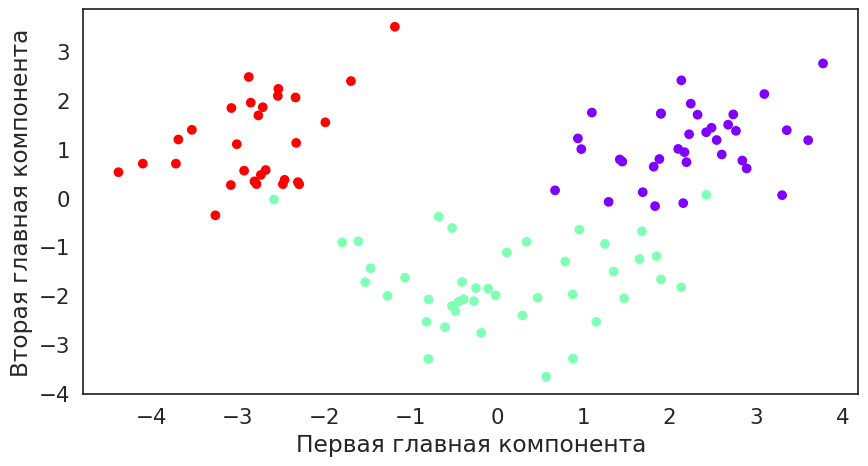

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(x=X_train_comp[:, 0], y=X_train_comp[:, 1], c=y_train, cmap='rainbow')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента');

**Ответ:**

Классы данных практически линейно разделимы: лишь 1-2 точки могут оказаться не на своем месте. Однако это утверждение верно только для тренировочной выборки и только в 2D. Если добавить тестовую выборку, линейная разделимость может ухудшиться. В случае 3D или более многомерного пространства данные могут быть разделены гиперплоскостью без особых проблем.

Постройте график зависимости качества логистической регрессии на тестовой выборке от числа компонент. Что можно наблюдать?

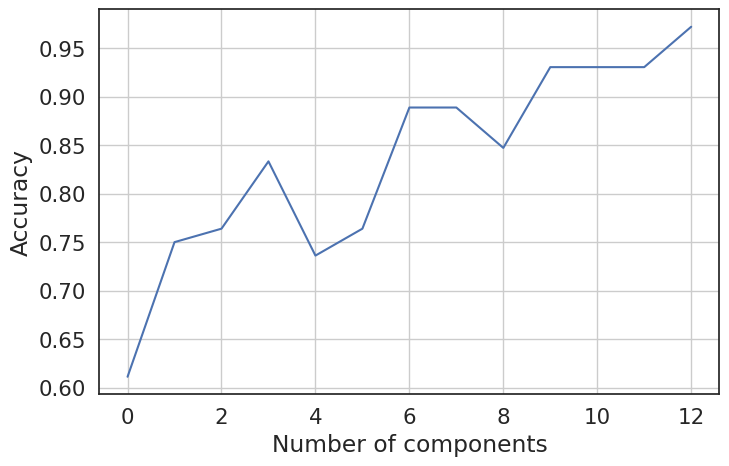

In [ ]:
accs = []

for i in range(pca.n_components_):
    lr = LogisticRegression(penalty='l2')
    lr.fit(X_train[:, :i+1], y_train)
    preds = lr.predict(X_test[:, :i+1])
    acc = accuracy(y_test, preds)
    accs.append(acc)

plt.figure(figsize=(8, 5))
plt.plot(accs)

plt.xlabel("Number of components")
plt.ylabel("Accuracy")
plt.grid()

In [ ]:
print(accs[-1])

0.9722222222222222


**Ответ:**

Точность повышается с увеличением числа компонентов, достигая своего пика при максимальном количестве. Однако даже наилучший результат в этом случае оказывается хуже, чем простая логистическая регрессия на исходных данных.


Попробуйте обучить обычную логистическую регрессию с Lasso-регуляризацией и выделить самые важные признаки. В чем отличие такого подхода от использования PCA-разложения?

*Указание.* Параметр регуляризации достаточно поперебирать вручную.

In [ ]:
lr = LogisticRegression(penalty='l1', solver='saga', multi_class='ovr')
lr.fit(X_train_s, y_train)
lr.coef_

array([[ 1.25368248,  0.        ,  0.47403753, -0.22220726,  0.        ,
         0.        ,  1.46812532,  0.        ,  0.        ,  0.        ,
         0.        ,  0.61605019,  2.52963329],
       [-1.52982549, -0.25915987, -0.8475845 ,  0.        , -0.09014534,
         0.        ,  0.        ,  0.        ,  0.56791214, -2.01880882,
         0.88640293,  0.        , -1.98282965],
       [ 0.        ,  0.39161949,  0.35530581,  0.        ,  0.        ,
         0.        , -2.09668091,  0.        , -0.26854077,  1.28114918,
        -1.44576609, -0.39637039,  0.        ]])

In [ ]:
X_train_new = X_train_s
X_test_new = X_test_s

to_drop = []

for i in range(lr.coef_.shape[1]):
    if lr.coef_[0][i] == lr.coef_[1][i] == lr.coef_[2][i] == 0:
        print(i)
        to_drop.append(i)

5
7


In [ ]:
X_train_new = np.delete(X_train_new, to_drop, 1)
X_train_s.shape, X_train_new.shape

((106, 13), (106, 11))

In [ ]:
X_test_new = np.delete(X_test_new, to_drop, 1)

lr1 = LogisticRegression(multi_class='multinomial')
lr1.fit(X_train_new, y_train)

preds = lr1.predict(X_test_new)
acc = accuracy(y_test, preds)
acc

0.9861111111111112

**Ответ:**

Результаты оказались аналогичными лучшему сценарию с PCA, но всё равно хуже, чем при использовании обычной логистической регрессии.

Вывод: простая логистическая регрессия — лучший вариант.

Какие есть преимущества и недостатки у снижения размерности перед обучением классификатора? Сделайте выводы по задаче.

**Вывод:**

В этом случае простая логистическая регрессия оказалась наилучшей. Это нормально, такое бывает.

Однако стоит отметить, что анализ весов логистической регрессии (feature importance) помогает отсеивать шумовые признаки, что может улучшить качество предсказаний. Но этот подход работает только для логрегрессии, тогда как в случае случайного леса важными могут оказаться совсем другие признаки.

PCA — более универсальный метод снижения размерности, который можно эффективно использовать на начальном этапе перед применением любой модели. Однако при этом мы неизбежно теряем информацию, что может негативно сказаться на качестве. PCA особенно полезен в задачах, где количество признаков значительно превышает количество образцов.

Кроме того, всегда стоит пробовать вариант без сложных методов. Он должен служить базовым уровнем, от которого мы будем отталкиваться.